In [ ]:
![Banner](BannerGitHub.png)

# Temporal aggregation and trend analysis of precipitation using Google Earth Engine 
## Purpose 
This exercise introduces you to working with time series of precipitation using [Google Earth Engine (GEE)](https://earthengine.google.com/) using python script in [jupyter notebook](https://jupyter.org/). 


## Prerequisites
- You should have an account in Google Earth Engine. If not done yet please [sign up now](https://earthengine.google.com/signup/).

## What you will learn
1. Temporal aggregation of spatial data on precipitation;
    1.1 create monthly sum maps from daily records of precipitation;
    1.2 create yearly mean maps from 1.1;
    1.3 create monthly climatology mean from 1.1;
3. Perform spatial subsets and areal aggregation;
4. perform trend analysis on the results obtained from 1-3
5. visualize the results as maps and time series. 

## What will you achieve
At the end of this exercise you will be able to use Google Earth Engine to access satellite data, preform temporal aggregation at various time scales and estimate the trend using python scripts in jupyter notebooks.

## Introduction 
Load the required libraries and authenticate your Google account

In [7]:
# import Google earth engine module
import ee
import geemap
import geemap.colormaps as cm
Map =geemap.Map()
import pandas as pd
import matplotlib.pyplot as plt

#ee.Authenticate()
#ee.Initialize()

## Data access  
Request Google Earth Engine to access CHIRPS rainfall data (available from end 1981)

In [8]:
CHIRPS_DS = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')

### Selecting the time bounds
Defining the start and end dates and filter the CHIRPS rainfall data

In [9]:
selected_bands = 'precipitation'
sY=1981
sM=1
sD=1
eY=2021
eM=12
eD =31

start_date = ee.Date.fromYMD(sY, sM, sD)
end_date   = ee.Date.fromYMD(eY, eM, eD)

precipitation  = CHIRPS_DS.select(selected_bands)
prec_1981_2021 = precipitation.filter(ee.Filter.date(start_date, end_date))



### Investigate the data
1. count the number of images in the image collection
2. print the properties of the first image
3. select the properties *system:band_names* and print it

In [10]:
count = prec_1981_2021.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount)+'\n')

first_image0 = prec_1981_2021.first()


image_props = geemap.image_props(first_image0)

print('Properties names: ',str(image_props.getInfo())+'\n')

Bname = first_image0.get('system:band_names')

print('system:band_names', Bname.getInfo())


Numbre of images is :  14974

Properties names:  {'IMAGE_DATE': '1981-01-01', 'NOMINAL_SCALE': 5565.974539663679, 'system:asset_size': '4.194949 MB', 'system:band_names': ['precipitation'], 'system:id': 'UCSB-CHG/CHIRPS/DAILY/19810101', 'system:index': '19810101', 'system:time_end': '1981-01-02 00:00:00', 'system:time_start': '1981-01-01 00:00:00', 'system:version': 1515007163707210.0}

system:band_names ['precipitation']


## Time aggregation

### Compute the monthly sum
To bin the daily data into monthly, we need two *for loops*, one for the years and one for the months. An Alternative to using *for loops* is to  apply the *.map* functionality twice, first on years and second on months.

The script below shows a nested functions of two application of *.map*. The core for binning daily to monthly data is the function *createSum*: for a specific year, it iterate on the months, whereby per month the daily data are summed. The for loop on the *years* would iterate on the years.


In [11]:
myears=range(sY,eY+1)
mmonths=range(1,eM+1)

In [12]:
years = ee.List.sequence(sY, eY)
months = ee.List.sequence(sM, eM)
def getMonthlySum(iy):
    def createSum(im):
        sDate = ee.Date.fromYMD(iy, im, sD)
        eDate = sDate.advance(1, 'month')
        monthFiltered = prec_1981_2021.filter(ee.Filter.date(sDate, eDate))
        msum = monthFiltered.reduce(ee.Reducer.sum())
        return msum.set({
            'system:time_start': sDate.millis(),
            'system:time_end': eDate.millis(),
            'year': iy,
            'month': im,
            'date': sDate.millis()})
    return months.map(createSum)

monthlyChirps = ee.ImageCollection.fromImages(years.map(getMonthlySum).flatten())

#### Define the mapping parameters


In [13]:
val= cm.palettes.Spectral
palette=val.default
Vis = {
  'min': 0,
  'max': 200,
  'palette': palette}

#### Apply monthly binning 
Run the monthly binning function and visualize the first month and investigate the results:
1. count the number of images in the image collection resulting from the function *getMonthlySum*
2. add the the first image and visualize, use the *system:time_start* property as the name of the layer 

In [14]:
count = monthlyChirps.size()
valCount=count.getInfo()
print('Count: ', str(valCount)+'\n')

first_image = monthlyChirps.first()

iname=ee.Date(first_image.get('system:time_start')).format("yyyy-MM-dd")
print(iname.getInfo())
Map.addLayer(first_image, Vis, str(iname.getInfo()))
Map

Count:  492

1981-01-01


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Compute the monthly climatology
**Monthly climatology** is the the mean of a month over all years of observations.

The function *getMonthlyClimatology* for each month (from 1 to 12) will average all years of observations.

In [15]:
def getMonthlyClimatology(mm):
    img = monthlyChirps.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

In [16]:
MonthlyClim= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology).flatten()) 

#### Check 
Check the number of bands in the image collection resulting form the function *getMonthlyClimatology* and visualize the first month.

In [17]:
count = MonthlyClim.size()
valCount=count.getInfo()
print('Number of months count: ', str(valCount)+'\n')

first_image = MonthlyClim.first()

iname=(first_image.get('month').getInfo())
Map.addLayer(first_image, Vis, 'Monthly Climatology of:  '+str(iname))
Map


Number of months count:  12



Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

### Compute the yearly mean
The function *getYearlyMean* will take a list of years ,i.e. [1982-2021], and per year will filter the data for all months and average them.  

In [18]:
def getYearlyMean(yy):
    img = monthlyChirps.filter(ee.Filter.calendarRange(yy,yy , 'year')).filter(ee.Filter.calendarRange(sM, eM, 'month'))
    ymean = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(yy,sM,1)
    return ymean.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': yy,
        'month': sM,
        'date': timeStamp.millis()})
yearlymean= ee.ImageCollection.fromImages(years.map(getYearlyMean).flatten())   

#### Check 
Check the number of bands in the image collection resulting form the function *getYearlyMean* and visualize the first year.

In [ ]:
count = yearlymean.size()
valCount=count.getInfo()
print('Number of years count: ', str(valCount)+'\n')

first_image = yearlymean.first()

iname=iname=(first_image.get('year').getInfo())

Map.addLayer(first_image, Vis, str(iname))
Map

Number of years count:  41



Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Time series extraction 
To work with a time series you can extract a point or a region. Here we will extract the time series of a country.
To be able to do so the following steps are needed
1. Select the region of interest (ROI);
2. Clip the image to the ROI and average over the region;
3. Extract the time series of the areal average;


###  Select the region of interest

In [ ]:
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
Uganda = countries.filter(ee.Filter.eq('ADM0_NAME','Uganda'))
Uganda_g = Uganda.geometry()

### Area average and values extraction
The function *getTM4RoI* will itrate on the images in an image collection and use the nested function *iter_func* to extract the date and calculate the mean of a region using *.reduceRegion*. The function will return these values as a list of two columns ['Dates', 'AMR'].


In [ ]:
def getTM4RoI(imgcol,nname):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = Uganda_g,
            scale = 5000,
            maxPixels=1e15)
        val=stat.get(nname)
        newlist = ee.List(newlist)
        return ee.List(newlist.add([date, val]))
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

### Convert to a Data Frame
The function *Convert2TM_DF* will take the generated list from *getTM4RoI* and convert to a *Pandas Data frame* with recognizable dates. This step will make time series analysis much easier. *Pandas Data frame* is a python library and is outside GEE.



In [ ]:
def Convert2TM_DF(inList):
    DF=pd.DataFrame(inList,columns=['Dates' ,'AMR [mm]'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    return DF

#### Extract time series on monthly climatology
To do so, apply the function *getTM4RoI* first and then use its output in the function *Convert2TM_DF*
Or you can do it in one run *res=Convert2TM_DF(getTM4RoI(ImgCol,Name))* as shown in later examples.

In [ ]:
inList = getTM4RoI(MonthlyClim,'precipitation_sum_mean')
TM_MC  = Convert2TM_DF(inList)

##### Visualize the monthly climatology with Panda capabilities

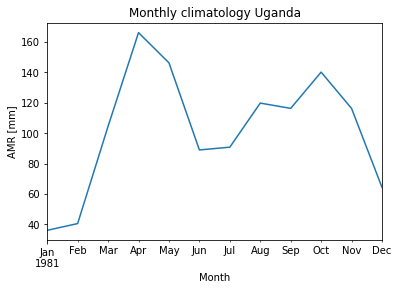

In [ ]:
TM_MC_ax=TM_MC.plot(kind='line',
                    legend= False,
                    ylabel='AMR [mm]',
                    xlabel='Month',
                    title='Monthly climatology Uganda')

#### Extract time series on yearly mean and visualize
To do so, apply the function *getTM4RoI* first and then use its output in the function *Convert2TM_DF*.
Here we do it in one run *res = Convert2TM_DF( **getTM4RoI ( ImgCol,Name )** )* as shown in later examples.


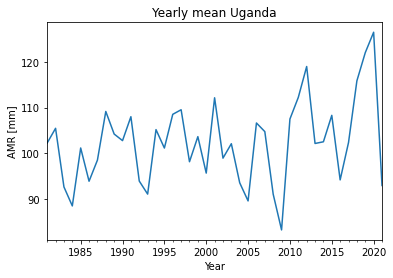

In [ ]:
TM_Y=Convert2TM_DF(getTM4RoI(yearlymean,'precipitation_sum_mean'))
TM_Y_ax=TM_Y.plot(kind='line',
                   legend= False,
                  ylabel='AMR [mm]',
                  xlabel='Year',
                  title='Yearly mean Uganda')

#### Extract time series on monthly mean and visualize
To do so, apply the function *getTM4RoI* first and then use its output in the function *Convert2TM_DF*.
Here we do it in one run *res = Convert2TM_DF( **getTM4RoI ( ImgCol,Name )** )* as shown in later examples.


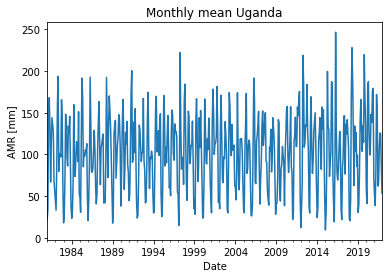

In [ ]:
TM_M=Convert2TM_DF(getTM4RoI(monthlyChirps,'precipitation_sum'))
TM_M_ax=TM_M.plot(kind='line',
                   legend= False,
                  ylabel='AMR [mm]',
                  xlabel='Date',
                  title='Monthly mean Uganda')

# End of exercise